# GBM in Azure ML Jupyter Notebook
Lixun Zhang  
Nov 23, 2015

## 1 Introduction
In this notebook we'll demonstrate how to fit a GBM model using R. 

### 1.1 Target audience
The target audience are those who have some experience with R (e.g., fitting a linear model) and understand deploying web services to Azure. If you're comfortable with the content in the [Tutorial][tut link], you are good to go.

### 1.2 Why GBM in R notebooks
GBM is well-known among data scientists and as a [Kaggle Profile][kaggle link] explains, it has several major advantages compared with traditional statistical models like linear regression:
    1. it automatically approximates non-linear transformations and interactions
    2. it treats missing values without having to fill in values or remove observations
    3. monotonic transformation of features won't influence the model's performance

For users who are used to fitting GBM models in Azure ML Experiments, a major advantage of using Azure ML notebooks is that there are more modeling options. For example, when the response variable is continunous you can use the "Boosted Decision Tree Regression" module for Experiments to fit a GBM model. This module, however, does not allow users to specify the types of loss functions (for statisticians, this means that you can't specify the distribution for the response variable). On the other hand, with the "gbm" package in R, you can choose from a wide variety of loss functions. 

## 2 Data
In this example, we'll use the housing data from the R package "MASS." There are 506 rows and 14 columns in the dataset. Available information includes median home price, average number of rooms per dwelling, crime rate by town, etc. More information about this dataset can be found at [UCI][uci link] or by typing "help(Boston)" in an R terminal.

## 3 GBM model
### 3.1 Estimate hyperparameters
In a GBM model, there are several hyperparameters and we need to estimate them first. One way to estimate these parameters is to use cross validation on a parameter-grid. In our example, we'll optimize the following parameters over a grid: number of estimators, maximum tree depth, minimum number of samples on a split, and learning rate. To do this we start by providing several values for each of them and create a set of combinations, each combination consisting of one value for each parameter. Then for each combination we use cross validation to estimate the performance, using root mean squared error as performance metric. The "caret" package will be used in this process.

[tut link]: ???
[kaggle link]: http://blog.kaggle.com/2015/06/22/profiling-top-kagglers-owen-zhang-currently-1-in-the-world/
[uci link]: https://archive.ics.uci.edu/ml/datasets/Housing

Loading required package: lattice
Loading required package: ggplot2
Loading required package: gbm
Loading required package: survival

Attaching package: 'survival'

The following object is masked from 'package:caret':

    cluster

Loading required package: splines
Loading required package: parallel
Loaded gbm 2.1.1
Loading required package: plyr


Stochastic Gradient Boosting 

506 samples
 13 predictor

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 406, 405, 405, 404, 404 
Resampling results across tuning parameters:

  shrinkage  interaction.depth  n.minobsinnode  n.trees  RMSE      Rsquared 
  0.001      2                  1                5000    3.898249  0.8206939
  0.001      2                  1               10000    3.702223  0.8365606
  0.001      2                  2                5000    3.871375  0.8226767
  0.001      2                  2               10000    3.690456  0.8378222
  0.001      4                  1                5000    3.439217  0.8596083
  0.001      4                  1               10000    3.247005  0.8738005
  0.001      4                  2                5000    3.460390  0.8580262
  0.001      4                  2               10000    3.287990  0.8711876
  0.010      2                  1                5000    3.381274  0.8627487
  0.010      2      

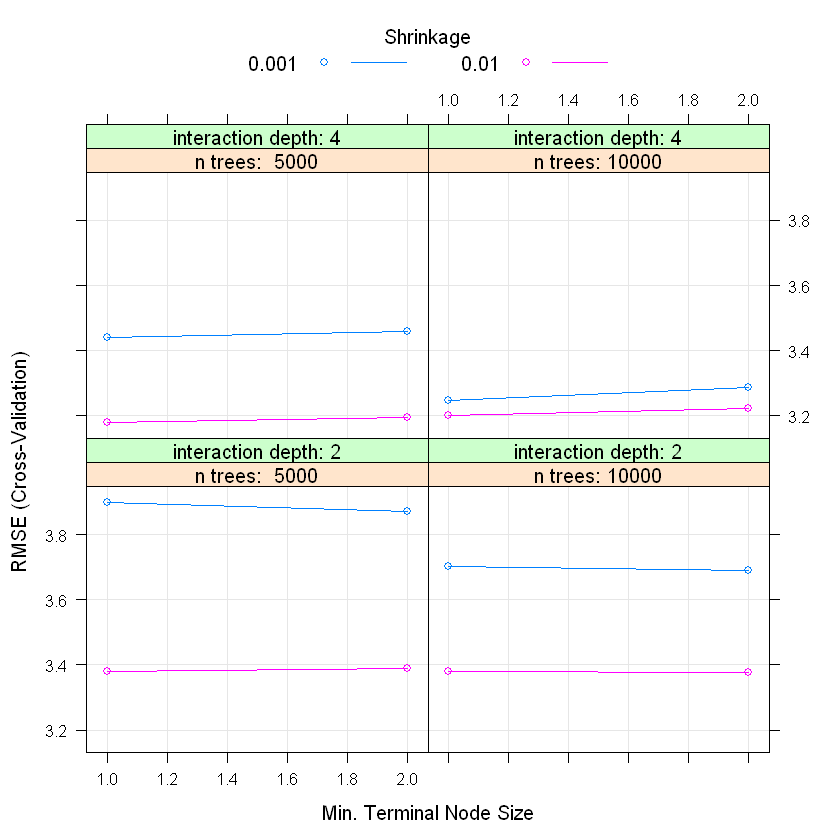

In [1]:
# show images inline
options(jupyter.plot_mimetypes = 'image/png')

# load the libraries
library(MASS)
library(caret)

# ensure results are repeatable
set.seed(123)

# prepare training scheme
control <- trainControl(method = "cv", number = 5)

# design the parameter tuning grid 
grid <- expand.grid(n.trees = c(5000, 10000, 15000), 
                    interaction.depth = c(2, 4, 8), 
                    n.minobsinnode = c(1, 2, 4), 
                    shrinkage = c(0.001, 0.01, 0.1))

grid <- expand.grid(n.trees = c(5000, 10000), 
                    interaction.depth = c(2, 4), 
                    n.minobsinnode = c(1, 2), 
                    shrinkage = c(0.001, 0.01))

# tune the parameters
gbm1 <- train(medv ~ ., data = Boston, method="gbm", distribution = "gaussian",
              trControl = control, verbose = FALSE, tuneGrid = grid, metric = "RMSE")

# summarize the model
print(gbm1)

# plot cv results
plot(gbm1)

### 3.2  Fit Model with Estimated Parameters
Based on the initial parameter estimates, we can look closely at the number of trees to determine the optimal value.

In [29]:
# fit the model
gbm2 <- gbm(medv ~ ., 
            distribution = "gaussian", 
            n.trees = 5000, 
            interaction.depth = 4, 
            n.minobsinnode = 1,
            shrinkage = 0.01, 
            cv.folds = 5,
            data = Boston)

gbm(formula = medv ~ ., distribution = "gaussian", data = Boston, 
    n.trees = 5000, interaction.depth = 4, n.minobsinnode = 1, 
    shrinkage = 0.01, cv.folds = 5)
A gradient boosted model with gaussian loss function.
5000 iterations were performed.
The best cross-validation iteration was 4600.
There were 13 predictors of which 13 had non-zero influence.


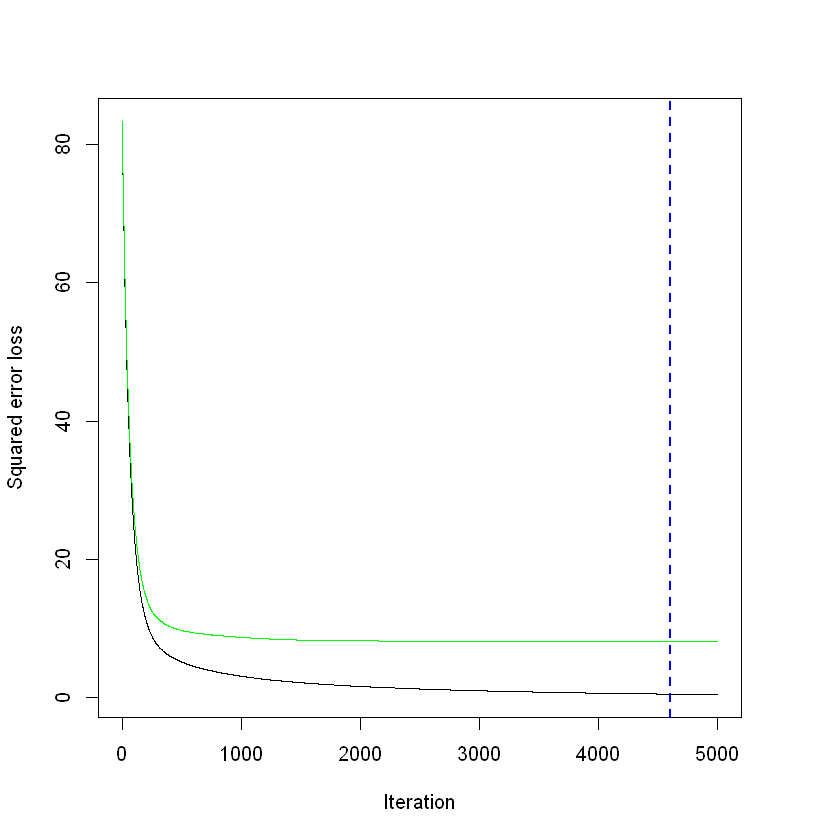

In [30]:
# print model
print(gbm2) 
# check performance using 5-fold cross-validation
best.iter <- gbm.perf(gbm2,method="cv")

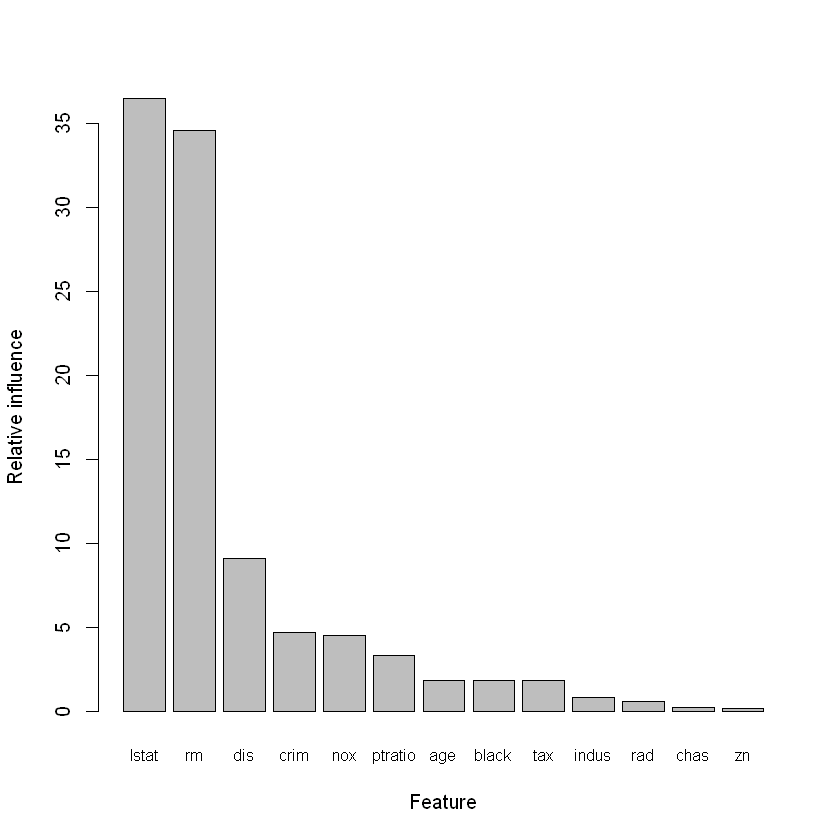

In [38]:
# check variable importance
f_imp <- summary(gbm2, n.trees = best.iter, plot = FALSE) 
# use a custom plot to show variable importance
barplot(f_imp$rel.inf, names.arg = f_imp$var, xlab = "Feature", ylab = "Relative influence", cex.names = 0.8)

## 4 Web service
### 4.1 Deploy a web service
With the developed model, we can deploy a web service so that others can use it to make predictions. The "AzureML" package will be used for this purpose. You'll need to provide the work space ID and authorization token for an Azure machine learning workspace. More information about this can be found the [Tutorial][tut link].

[tut link]: ???

In [32]:
# load the library
library(AzureML)

# workspace information
ws <- workspace(
  id = "b2bbeb56a1d04e1599d2510a06c59d87",
  auth = "a3978d933cd84e64ab583a616366d160"
)

# define predict function
mypredict <- function(newdata)
{
  require(gbm)
  res <- predict(gbm2, newdata, best.iter)
  res
}

# test the prediction function
newdata <- Boston[1, 1:13]
print(mypredict(newdata))

# Publish the service
ep <- publishWebService(ws = ws, fun = mypredict, name = "HousePricePredictionGBM", inputSchema = newdata)

[1] 24.21669


### 4.2 Consume a web service
The [Tutorial][tut link] describes three ways of consuming the web service and we'll use one of those approaches here.

[tut link]: ???

In [33]:
# retrieve web service information
service_id <- ep$WebServiceId
ep_price_pred <- endpoints(ws, service_id)

print(service_id)

[1] "202eac1392e211e581787981b4f9baca"


In [34]:
# consume
consume(ep_price_pred, newdata)

Request failed with status 401. Retrying request...


,ans
1,24.21669


## 5 Conclusion
Using the Boston housing dataset, we started the analysis by estimating the parameters in the GBM model. Then we fitted the model and examined variable importance. A web service was also deployed based on the selected model.

In addition to the Gaussian distribution which uses squared error loss function, the "gbm" package allows for several other distributions: laplace which uses absolute loss, t-distribution which uses t-distribution loss, etc. 

The "caret" package makes it possible to easily tune the hyperparameters on a grid. 

---  
Created by a Microsoft Employee.  
Copyright © Microsoft. All Rights Reserved.